# Overview


This notebook describes the different stages to build up different deep learning models trained over the dataset called **FakeNewsNet** by using pretrained **BERT** Embeddings, for the automatic fake news detection

List of Deep Learning algorithms included 
- 1D CNN
- LSTM
- BiLSTM



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-07-06 02:16:06.366948: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-06 02:16:06.372185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-06 02:16:06.372201: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

#### Loading the Full prepared dataset - FakeNewsNet cleaned data using nltk library on earlier works

In [2]:
#creating a data frame
df = pd.read_csv("Updated//full_dataset_fakenewsnet_cleaned_using_nltk.csv")

***
## 2. Dataset Cleaning and Preprocessing

#### Remove null values in the fulltext column

In [5]:
df = df[df['fulltext'].notna()]

***

## 3. Model Training and Evaluation

### Splitting dataset into Features and Class labels

In [8]:
x=df[['fulltext']]
y=df[['class']]

#### Train and Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,stratify=y, random_state=0)

### BERT Embedding Layer

##### Download the Pretrained BERT embedding encoder  model from tensorflow hub

In [ ]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

#### Building model using tf.keras and hub. from sentences to embeddings.

Inputs:
- input token ids is tokenizer converts tokens using vocab file.
- input masks are either 0 or 1. 1 for useful tokens, 0 for padding.
- segment ids are either 0 or 1. For 2 text training: 0 for the first one, 1 for the second one.

Outputs:
 - pooled_output of shape `[batch_size, 768]` with representations for the entire input sequences
 - sequence_output of shape `[batch_size, max_seq_length, 768]` with representations for each input token (in context)

In [11]:
MAX_SEQ_LEN=256
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,name="segment_ids")

In [14]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


#### Functions for Generating segments and masks based on the original BERT

In [13]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))


def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

#### Create the tokenizer with the BERT layer and import it tokenizer using the original vocab file.
##### Instantiate Tokenizer with vocab

In [15]:
FullTokenizer=bert.bert_tokenization.FullTokenizer

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)


##### Helper function to create bert input array format for the given sentences

In [17]:
def create_single_input(sentence,MAX_LEN):
    stokens = tokenizer.tokenize(sentence)
    stokens = stokens[:MAX_LEN]
    stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
    ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
    masks = get_masks(stokens, MAX_SEQ_LEN)
    segments = get_segments(stokens, MAX_SEQ_LEN)

    return ids,masks,segments

def create_input_array(sentences):
    input_ids, input_masks, input_segments = [], [], []
    for sentence in tqdm(sentences,position=0, leave=True):
        ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
    return [np.asarray(input_ids, dtype=np.int32), 
                    np.asarray(input_masks, dtype=np.int32), 
                    np.asarray(input_segments, dtype=np.int32)]

#### Convert the train and test sentences to bert input array format 

In [18]:
train_sentences=X_train.fulltext.values
train_y = y_train.values
train_inputs=create_input_array(train_sentences)

test_sentences=X_test.fulltext.values
test_y = y_test.values
test_inputs=create_input_array(test_sentences)

100%|██████████| 4073/4073 [00:32<00:00, 125.12it/s]


####  User defined helper functions to plot training and testing accuracy of the trained model

This function is using to save the loss and accuracy metrics of the training and test sets from the given input parameter which is a keras history callback object obtained during the model traning

In [19]:
import matplotlib.pyplot as plt

def plot_loss_and_acc_from_hist2(hist_df):
    print('Training Accuracy :',hist_df.iloc[-1]['accuracy'])
    print('Validation Accuracy :',hist_df.iloc[-1]['val_accuracy'])
    print('Precision :',hist_df.iloc[-1]["precision"])
    print('Recall :',hist_df.iloc[-1]["recall"])
    print('F1 Score :',hist_df.iloc[-1]["f1score"])
    train_loss = hist_df["loss"]
    train_acc = hist_df["accuracy"]
    val_loss = hist_df["val_loss"]
    val_acc = hist_df["val_accuracy"]
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");    

    

#### Helper function to plot confusion matrix and normalised confusion matrix plot

In [20]:
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

***
## Model Training

### 1D CNN

#### Checkpoint and EarlyStopping configuration setting for the model training

In [20]:
filepath_cnn = "outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_CNN_BERT_V1.h5" # Location to get the model
checkpoint_cnn = ModelCheckpoint(filepath_cnn, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_cnn = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_cnn = [checkpoint_cnn,es_cnn]

#### Build the model architecture

In [21]:
x= tf.keras.layers.Conv1D(256,kernel_size=3,padding='same', activation='relu')(sequence_output)
#x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

cnn_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

cnn_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 256, 768)]                'input_mask[0][0]',         

#### Model training

In [ ]:
history_cnn_bert=cnn_model.fit(train_inputs,train_y,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_cnn) 

#### Load the trained model and Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [ ]:
from tensorflow.keras.models import load_model
cnn_model = load_model('outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_CNN_BERT_V1.h5')

y_pred=cnn_model.predict(test_inputs)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))


#### Save the classification report to csv

In [27]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_CNN_BERT_clasifctnrpt.csv",index=False)
df.head()

,precision,recall,f1-score,support
0,0.875632,0.960823,0.916252,3063.000000
1,0.831461,0.586139,0.687573,1010.000000
accuracy,0.867911,0.867911,0.867911,0.867911
macro avg,0.853546,0.773481,0.801912,4073.000000
weighted avg,0.864679,0.867911,0.859545,4073.000000


**Plot confusion matrix and  normalised also**

In [ ]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakenewsnet_dl_bert//fakenewsnet_cnn_cmtrx.png"
path2="outputs//fakenewsnet_dl_bert//fakenewsnet_cnn_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

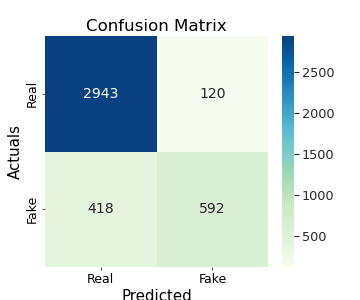

In [28]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_bert//fakenewsnet_cnn_cmtrx.png")

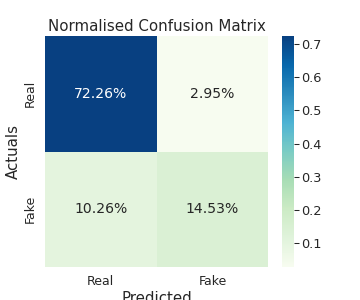

In [29]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_bert//fakenewsnet_cnn_ncmtrx.png")

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.8786757588386536
Validation Accuracy : 0.8621350526809692
Precision : 0.8314606741573034
Recall : 0.5861386138613861
F1 Score : 0.6875725900116144


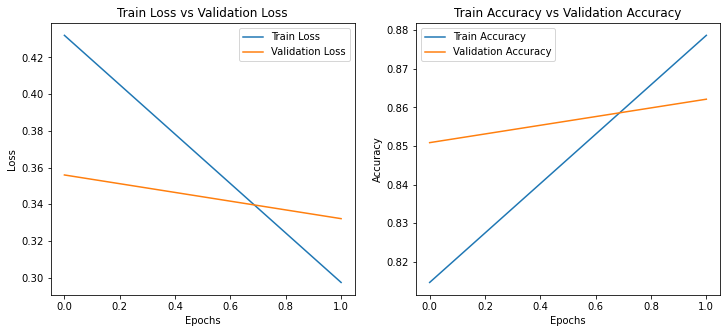

In [23]:
hist_df = pd.read_csv("outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_CNN_BERT_V1_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("CNN Completed")

### LSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [19]:
# Model Checkpoint and EarlyStopping
filepath_lstm = "outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_LSTM_BERT_PRETRAINED_V2.h5" # Location to get the model
checkpoint_lstm = ModelCheckpoint(filepath_lstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_lstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_lstm = [checkpoint_lstm,es_lstm]

#### Build the model architecture

In [20]:
x= tf.keras.layers.LSTM(256)(sequence_output)
x = tf.keras.layers.Dense(64, activation="relu")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

lstm_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

lstm_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])

In [21]:
clear_session()

In [22]:
lstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 256, 768)]                'input_mask[0][0]',         

#### Model training

In [ ]:
history_lstm_bert=lstm_model.fit(train_inputs,train_y,epochs=3,batch_size=200,validation_split=0.2,shuffle=True, callbacks=callbacks_list_lstm) 

#### Load the trained model and Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [23]:
from tensorflow.keras.models import load_model
lstm_model = load_model('outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_LSTM_BERT_PRETRAINED_V2.h5',custom_objects={'KerasLayer':hub.KerasLayer})

y_pred=lstm_model.predict(test_inputs)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
128/128 [==============================] - 230s 2s/step
Accuracy score : 0.8669285538914805
precision = 0.7947103274559194
recall = 0.6247524752475248
f1score = 0.6995565410199557
[[2900  163]
 [ 379  631]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3063
           1       0.79      0.62      0.70      1010

    accuracy                           0.87      4073
   macro avg       0.84      0.79      0.81      4073
weighted avg       0.86      0.87      0.86      4073



#### Save the classification report to csv

In [24]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_LSTM_BERT_clasifctnrpt.csv",index=False)
df.head()

,precision,recall,f1-score,support
0,0.884416,0.946784,0.914538,3063.000000
1,0.794710,0.624752,0.699557,1010.000000
accuracy,0.866929,0.866929,0.866929,0.866929
macro avg,0.839563,0.785768,0.807047,4073.000000
weighted avg,0.862171,0.866929,0.861228,4073.000000


**Plot confusion matrix with normalised plot**

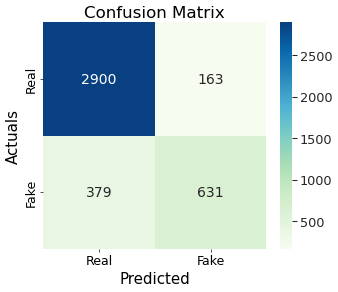

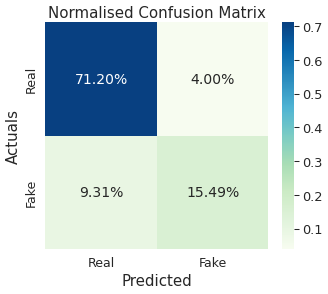

In [25]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakenewsnet_dl_bert//fakenewsnet_lstm_cmtrx.png"
path2="outputs//fakenewsnet_dl_bert//fakenewsnet_lstm_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.9841915369033812
Validation Accuracy : 0.8569674491882324
Precision : 0.7947103274559194
Recall : 0.6247524752475248
F1 Score : 0.6995565410199557


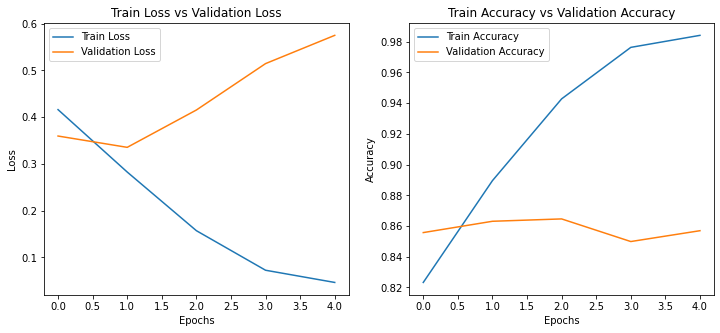

In [21]:
hist_df = pd.read_csv("outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_LSTM_BERT_V1_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("CNN Completed")

### Bi-LSTM

#### Checkpoint and EarlyStopping configuration setting for the model training


In [25]:
# Model Checkpoint and EarlyStopping
filepath_bilstm = "Updated//fakenewsnet_dl_bert//model_FAKENEWSNET_BILSTM_BERT_PRETRAINED_V2.h5" # Location to get the model
checkpoint_bilstm = ModelCheckpoint(filepath_bilstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm = [checkpoint_bilstm,es_bilstm]

#### Build the model architecture

In [26]:
x= tf.keras.layers.Bidirectional(LSTM(256))(sequence_output)
x = tf.keras.layers.Dense(64, activation="relu")(x)
out = tf.keras.layers.Dense(1, activation="sigmoid")(x)

bilstm_model = tf.keras.models.Model(
      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)

bilstm_model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(2e-5),
                  metrics=['accuracy'])

In [27]:
clear_session()

In [28]:
bilstm_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 256)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 256, 768)]                'input_mask[0][0]',         

#### Model training

In [ ]:
history_bilstm_bert=bilstm_model.fit(train_inputs,train_y,epochs=3,batch_size=200,validation_split=0.2,shuffle=True, callbacks=callbacks_list_bilstm) 

#### Load the trained model and Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [ ]:
from tensorflow.keras.models import load_model
bilstm_model = load_model('outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_BILSTM_BERT_PRETRAINED_V2.h5')

y_pred=bilstm_model.predict(test_inputs)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))



#### Save the classification report to csv

In [33]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_BILSTM_BERT_clasifctnrpt.csv",index=False)
df.head()

,precision,recall,f1-score,support
0,0.884748,0.922298,0.903133,3063.000000
1,0.729545,0.635644,0.679365,1010.000000
accuracy,0.851215,0.851215,0.851215,0.851215
macro avg,0.807147,0.778971,0.791249,4073.000000
weighted avg,0.846262,0.851215,0.847644,4073.000000


**Plot confusion matrix with normalised plot**

In [ ]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakenewsnet_dl_bert//fakenewsnet_bilstm_cmtrx.png"
path2="outputs//fakenewsnet_dl_bert//fakenewsnet_bilstm_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

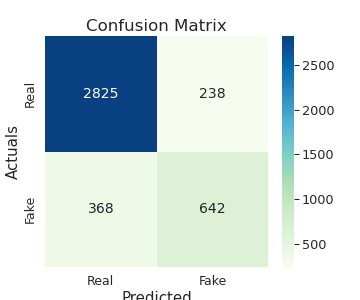

In [34]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_bert//fakenewsnet_bilstm_cmtrx.png")

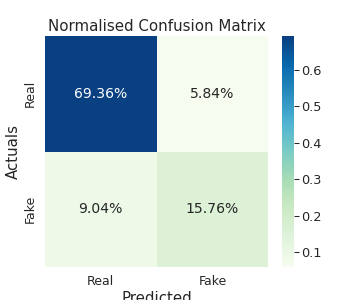

In [35]:
from IPython import display
display.Image("outputs//fakenewsnet_dl_bert//fakenewsnet_bilstm_ncmtrx.png")

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.9871844053268432
Validation Accuracy : 0.8471454977989197
Precision : 0.7295454545454545
Recall : 0.6356435643564357
F1 Score : 0.6793650793650793


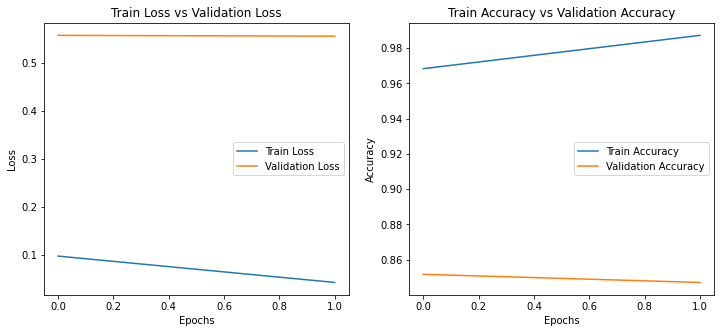

In [25]:
hist_df = pd.read_csv("outputs//fakenewsnet_dl_bert//model_FAKENEWSNET_BILSTM_BERT_V1_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("CNN Completed")